<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 301</h1>
<h1>How to model the effects of vaccination</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm.notebook import tqdm

import epidemik
from epidemik import EpiModel

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 6f3f47aa98b5141fcddbadd07afeedaa91c4cfb7

watermark : 2.4.3
tqdm      : 4.66.2
matplotlib: 3.8.0
epidemik  : 0.0.11
pandas    : 2.1.4
numpy     : 1.26.4



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## SIR Model

We start with the classical SIR model. It's not the most realistic, but it provides us with a simple model of a single wave epidemice (neglecting seasonality effects, social distancing measures, etc)

In [4]:
beta = 0.2
mu = 0.1
N = 1_000_000
I0 = 10

SIR = EpiModel()
SIR.add_interaction('S', 'I', 'I', beta)
SIR.add_spontaneous('I', 'R', mu)

In [5]:
print(SIR)

Epidemic Model with 3 compartments and 2 transitions:

S + I = I 0.200000
I -> R 0.100000

R0=2.00


And the dynamics are fairly simple as well:

In [6]:
SIR.integrate(365, S=N-I0, I=I0, R=0)

And the usual quick visualization

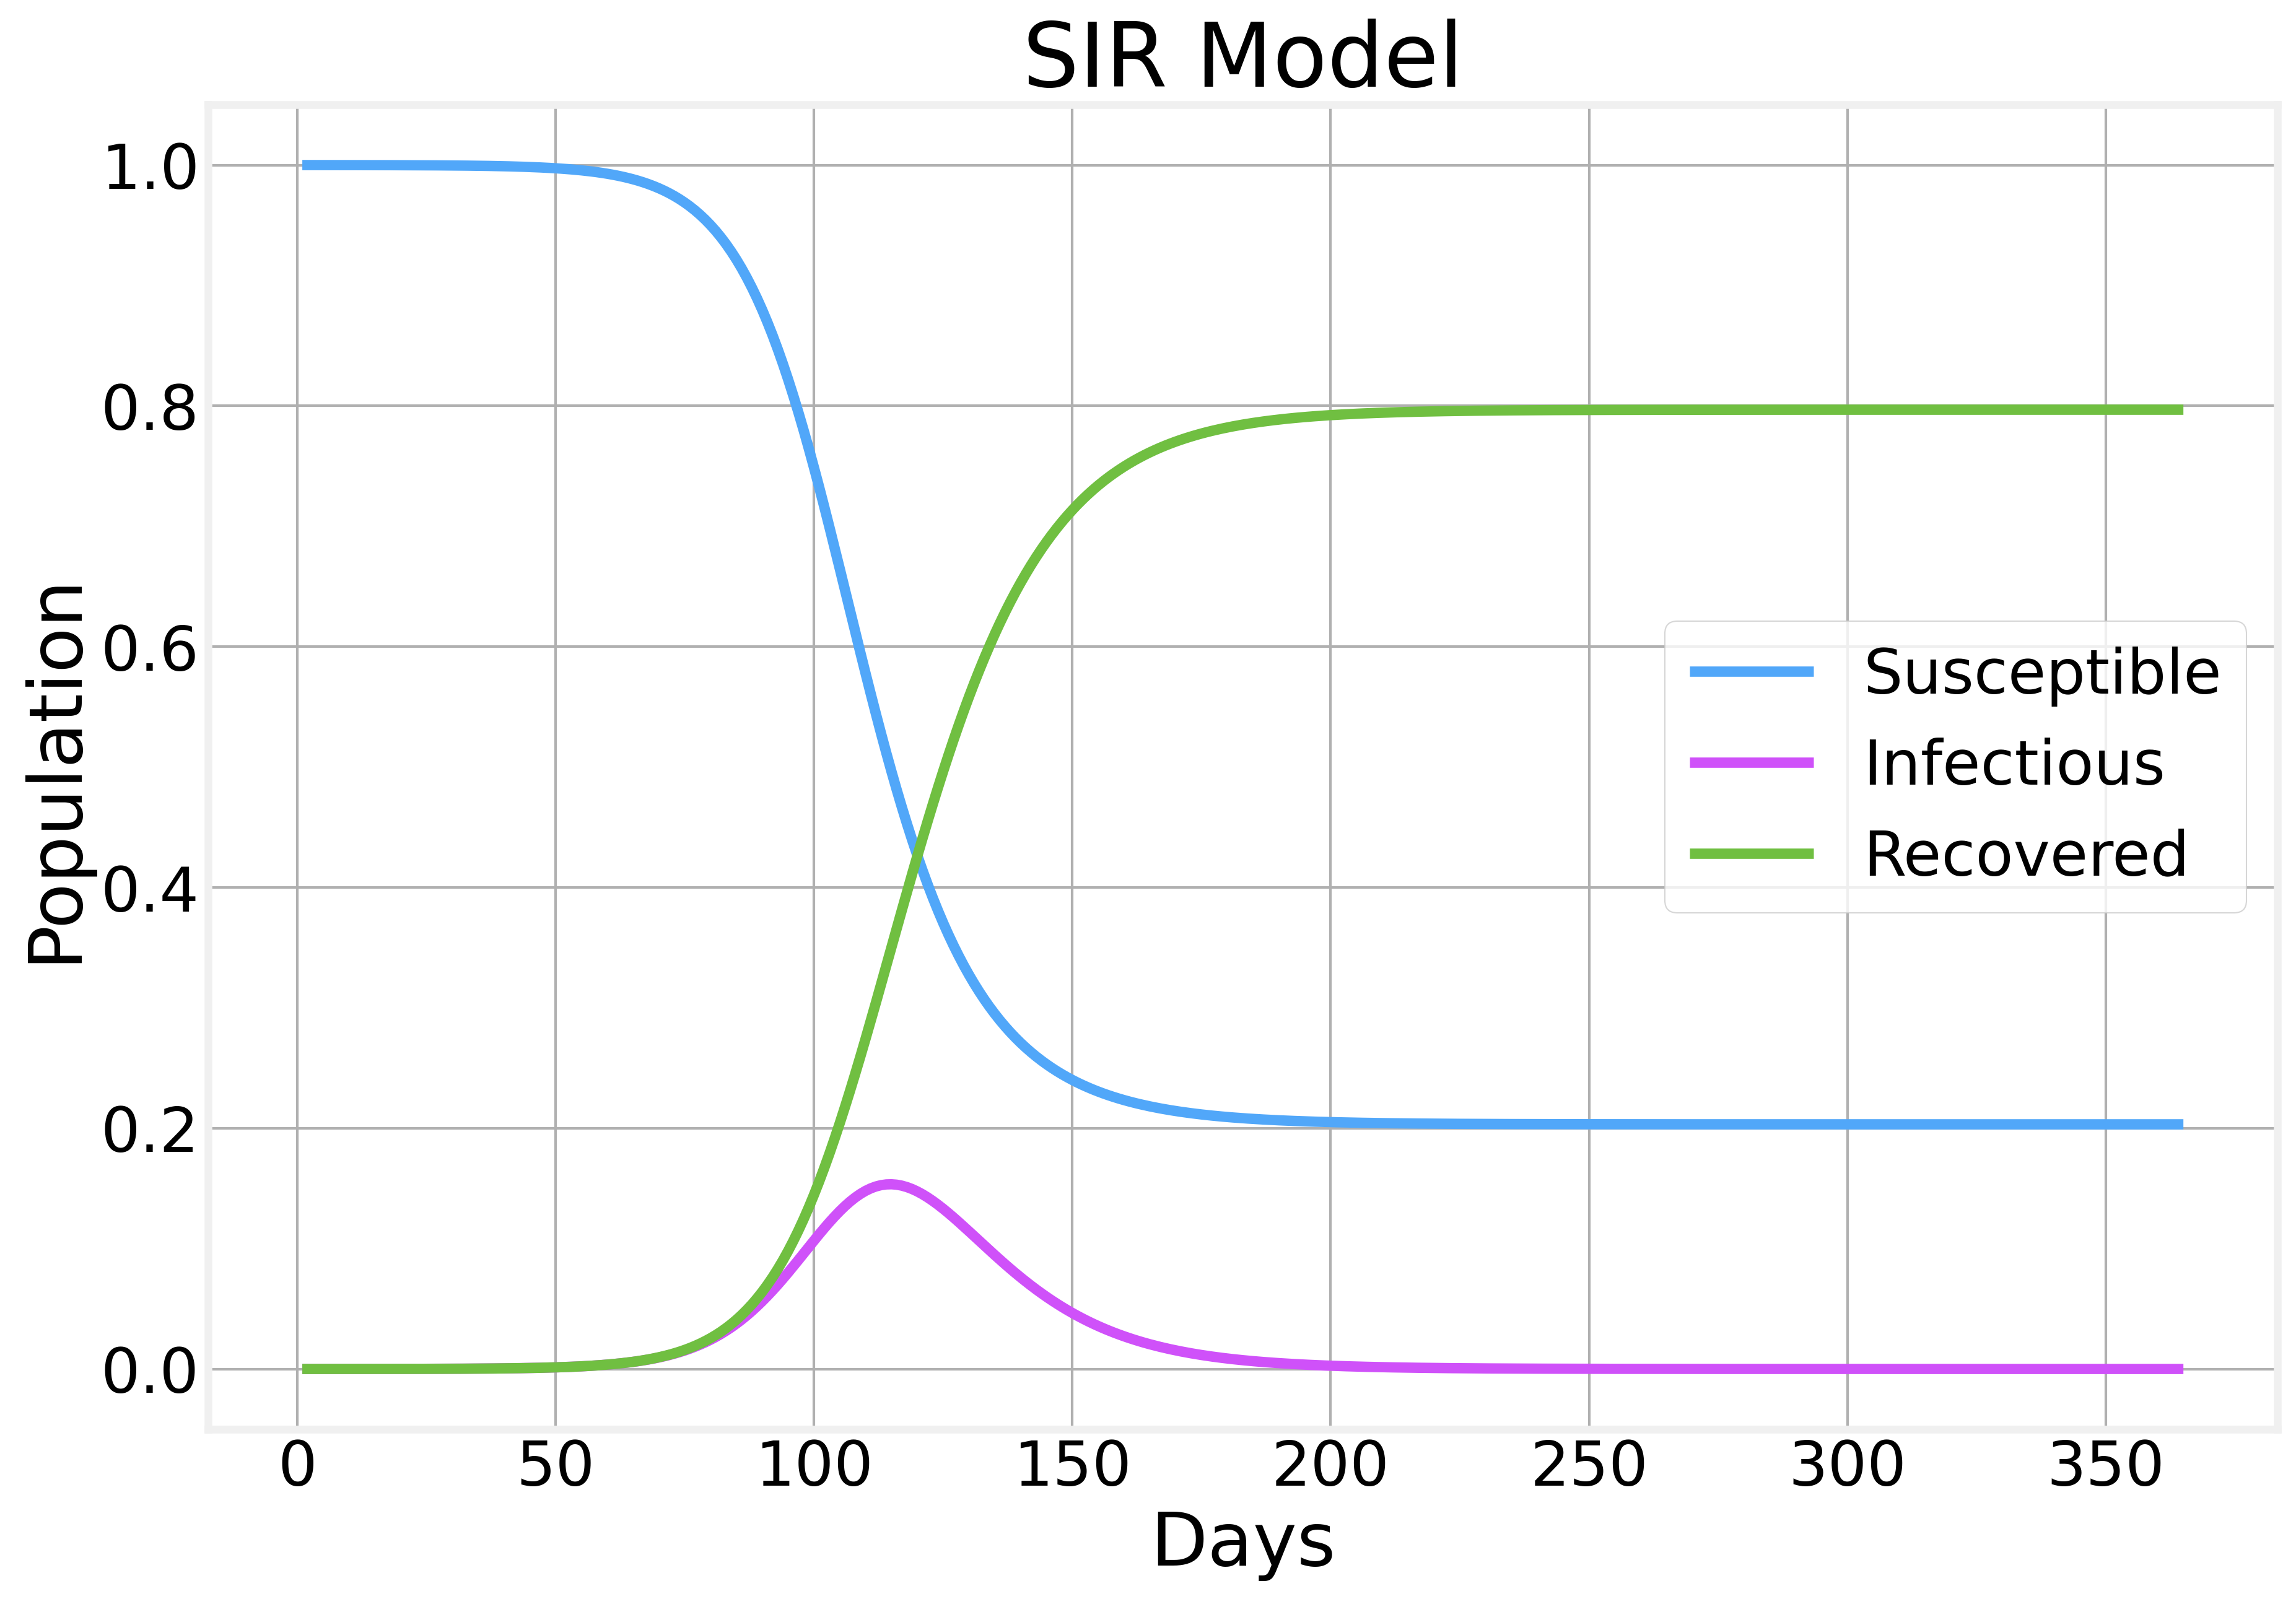

In [7]:
ax = SIR.plot('SIR Model', normed=True)
ax.legend(['Susceptible', 'Infectious', 'Recovered'])
ax.set_xlabel('Days')
plt.gcf().patch.set_facecolor((1, 1, 1))

The purple line is the number of currently infectious cases as a function of time. As we can see, not all of the population is infectious at the same time, and, in fact, only about $80\%$ of the population is ever infected, as shown by the green curve representing the fraction of recovered.

The typical bell curve you're likely to see (as asked to flatten) is simply the number of infectious individuals as a function of time:

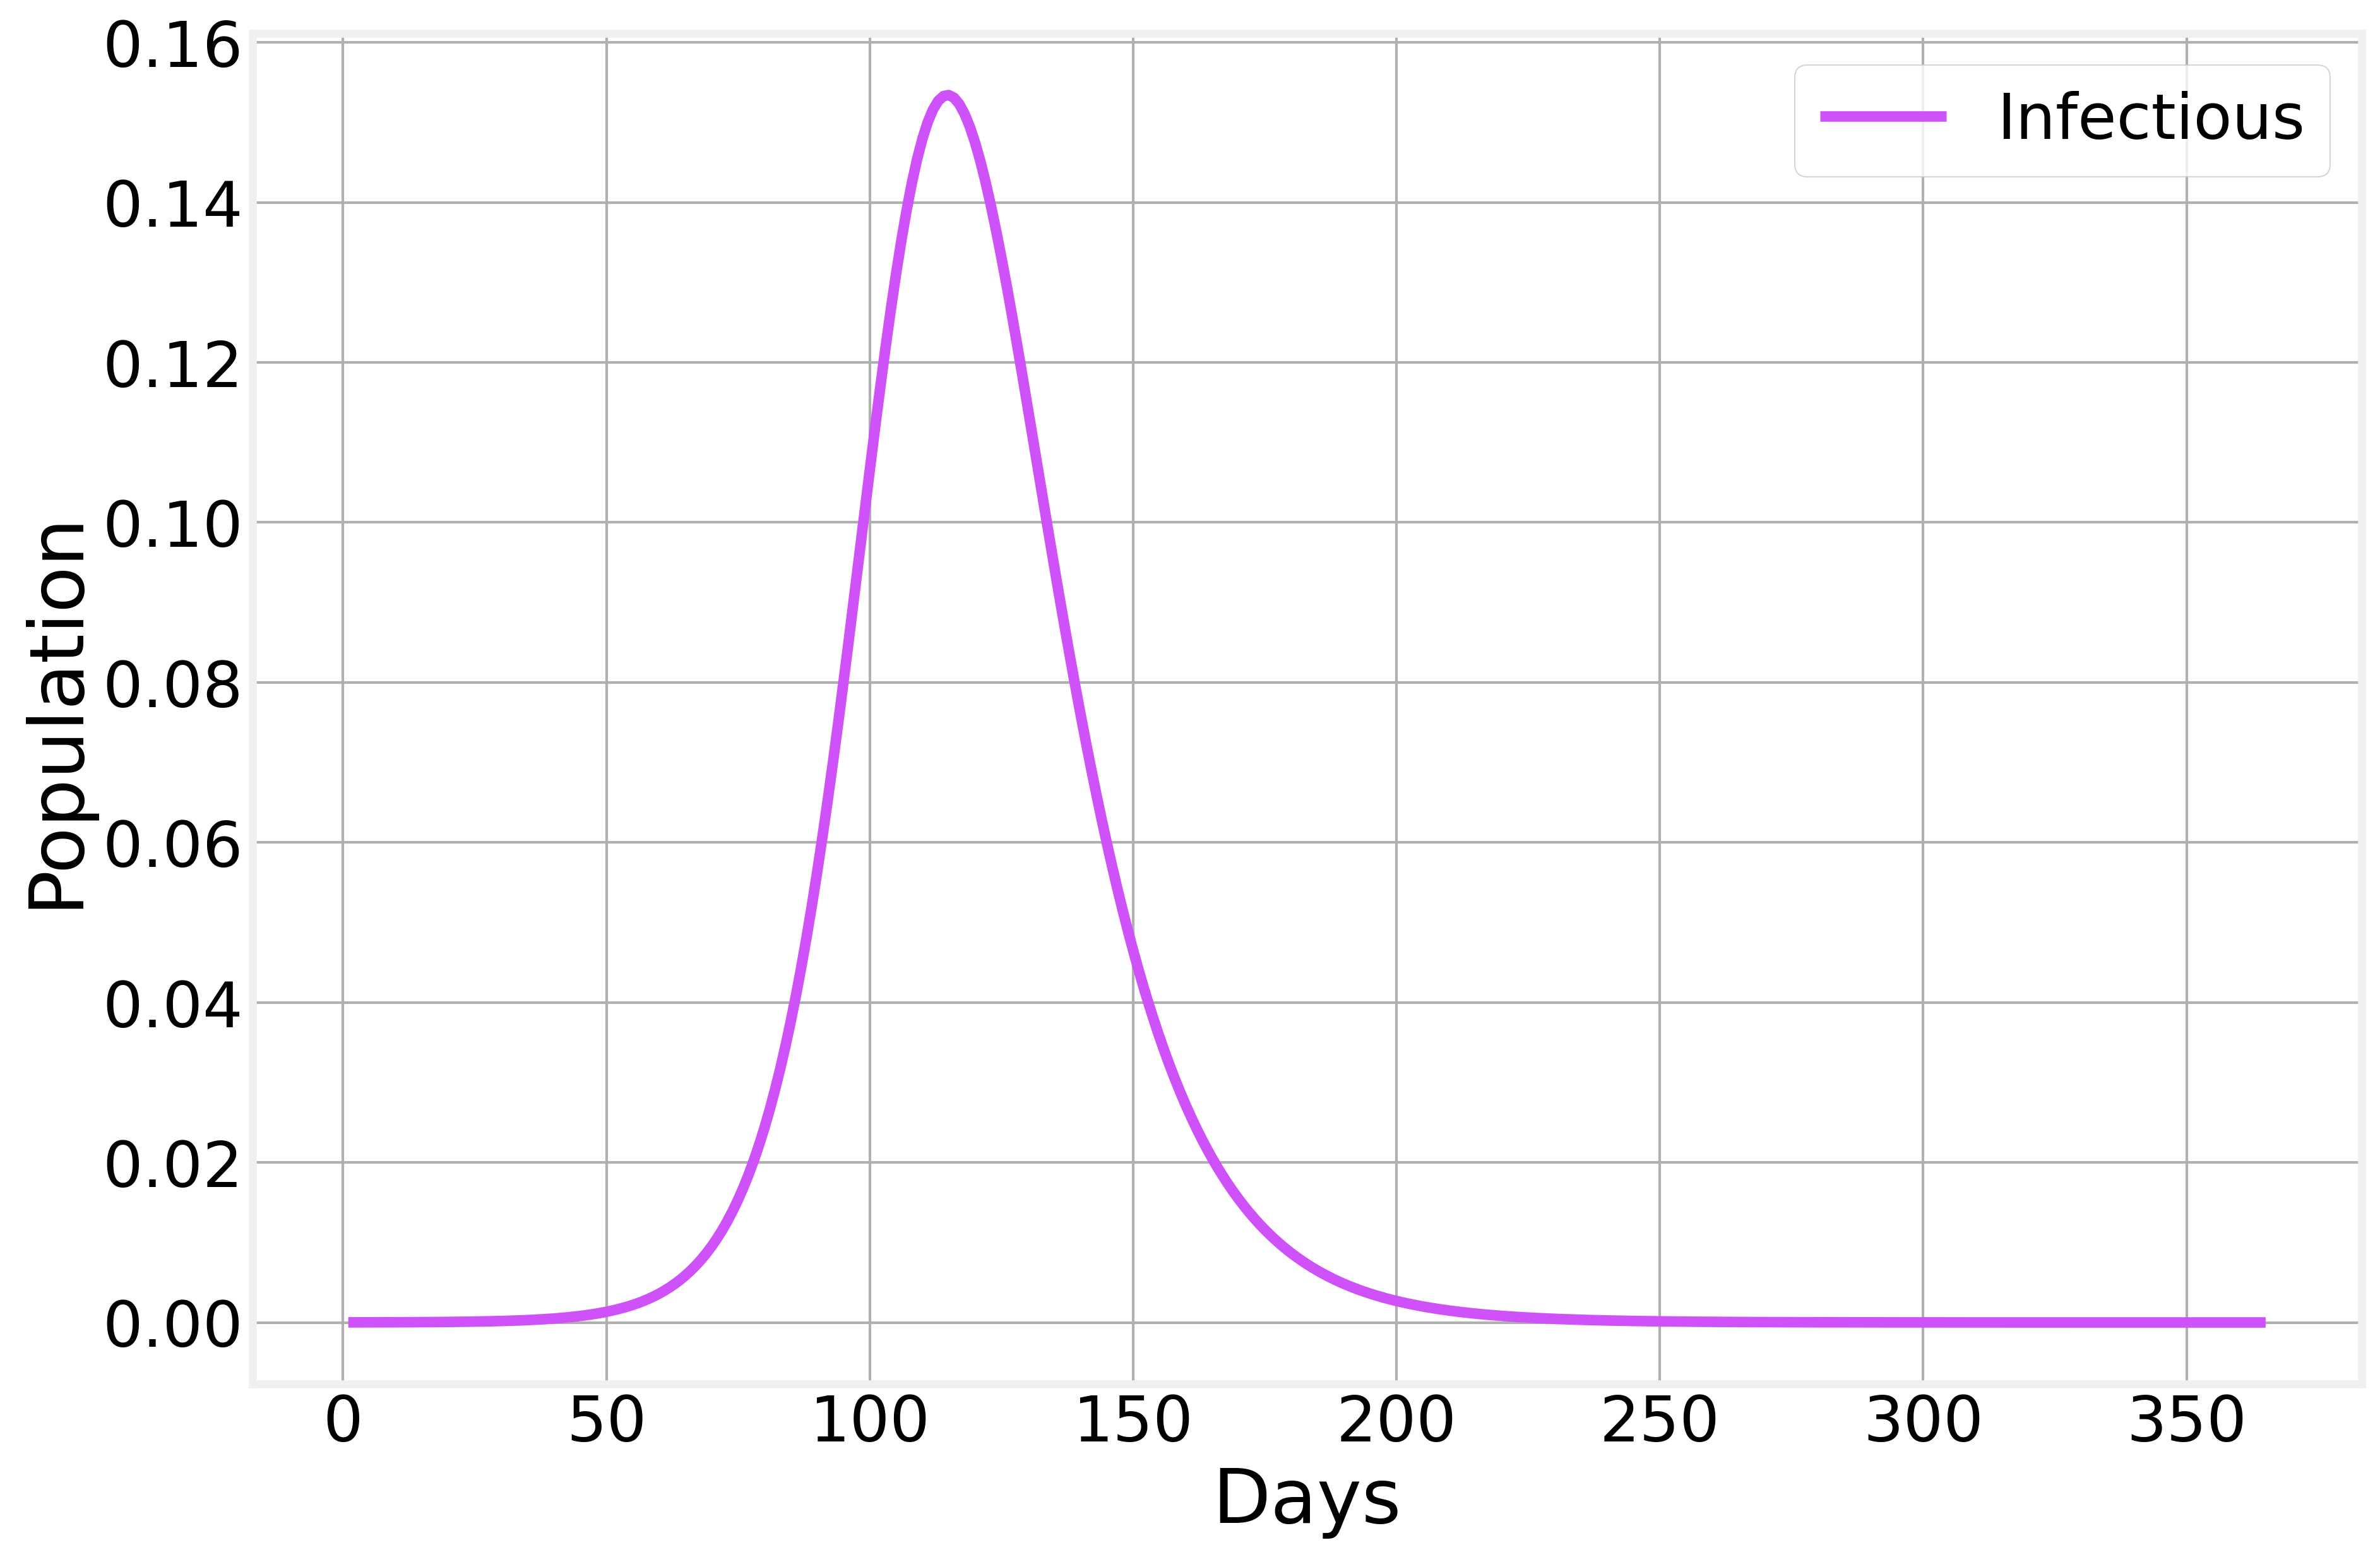

In [8]:
ax=(SIR.I/N).plot(label='Infectious', color=colors[1])
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.legend()
plt.gcf().patch.set_facecolor((1, 1, 1))

# Vaccination

A simple way to add vaccination to this model is to just spontaneously move individuals from the 'Susceptible' compartiment to a new 'Vaccinated' compartment at a fixed rate, say, 1% per day. To make it more realistic, we only turn on this transition after a few steps (to simulate the vaccine development process)

In [9]:
daily_vaccination_rate = 0.01
vaccination_start = 75

In [10]:
Vaccine_SIR = EpiModel()
Vaccine_SIR.add_interaction('S', 'I', 'I', beta)
Vaccine_SIR.add_spontaneous('I', 'R', mu)

# Add the vaccination transition
Vaccine_SIR.add_vaccination('S', 'V', 
                            daily_vaccination_rate, 
                            vaccination_start)

print(Vaccine_SIR)

Epidemic Model with 4 compartments and 3 transitions:

S + I = I 0.200000
S -> V 0.010000 starting at 75 days
I -> R 0.100000

R0=2.00


In [11]:
Vaccine_SIR.integrate(365, S=N-I0, I=I0, R=0)

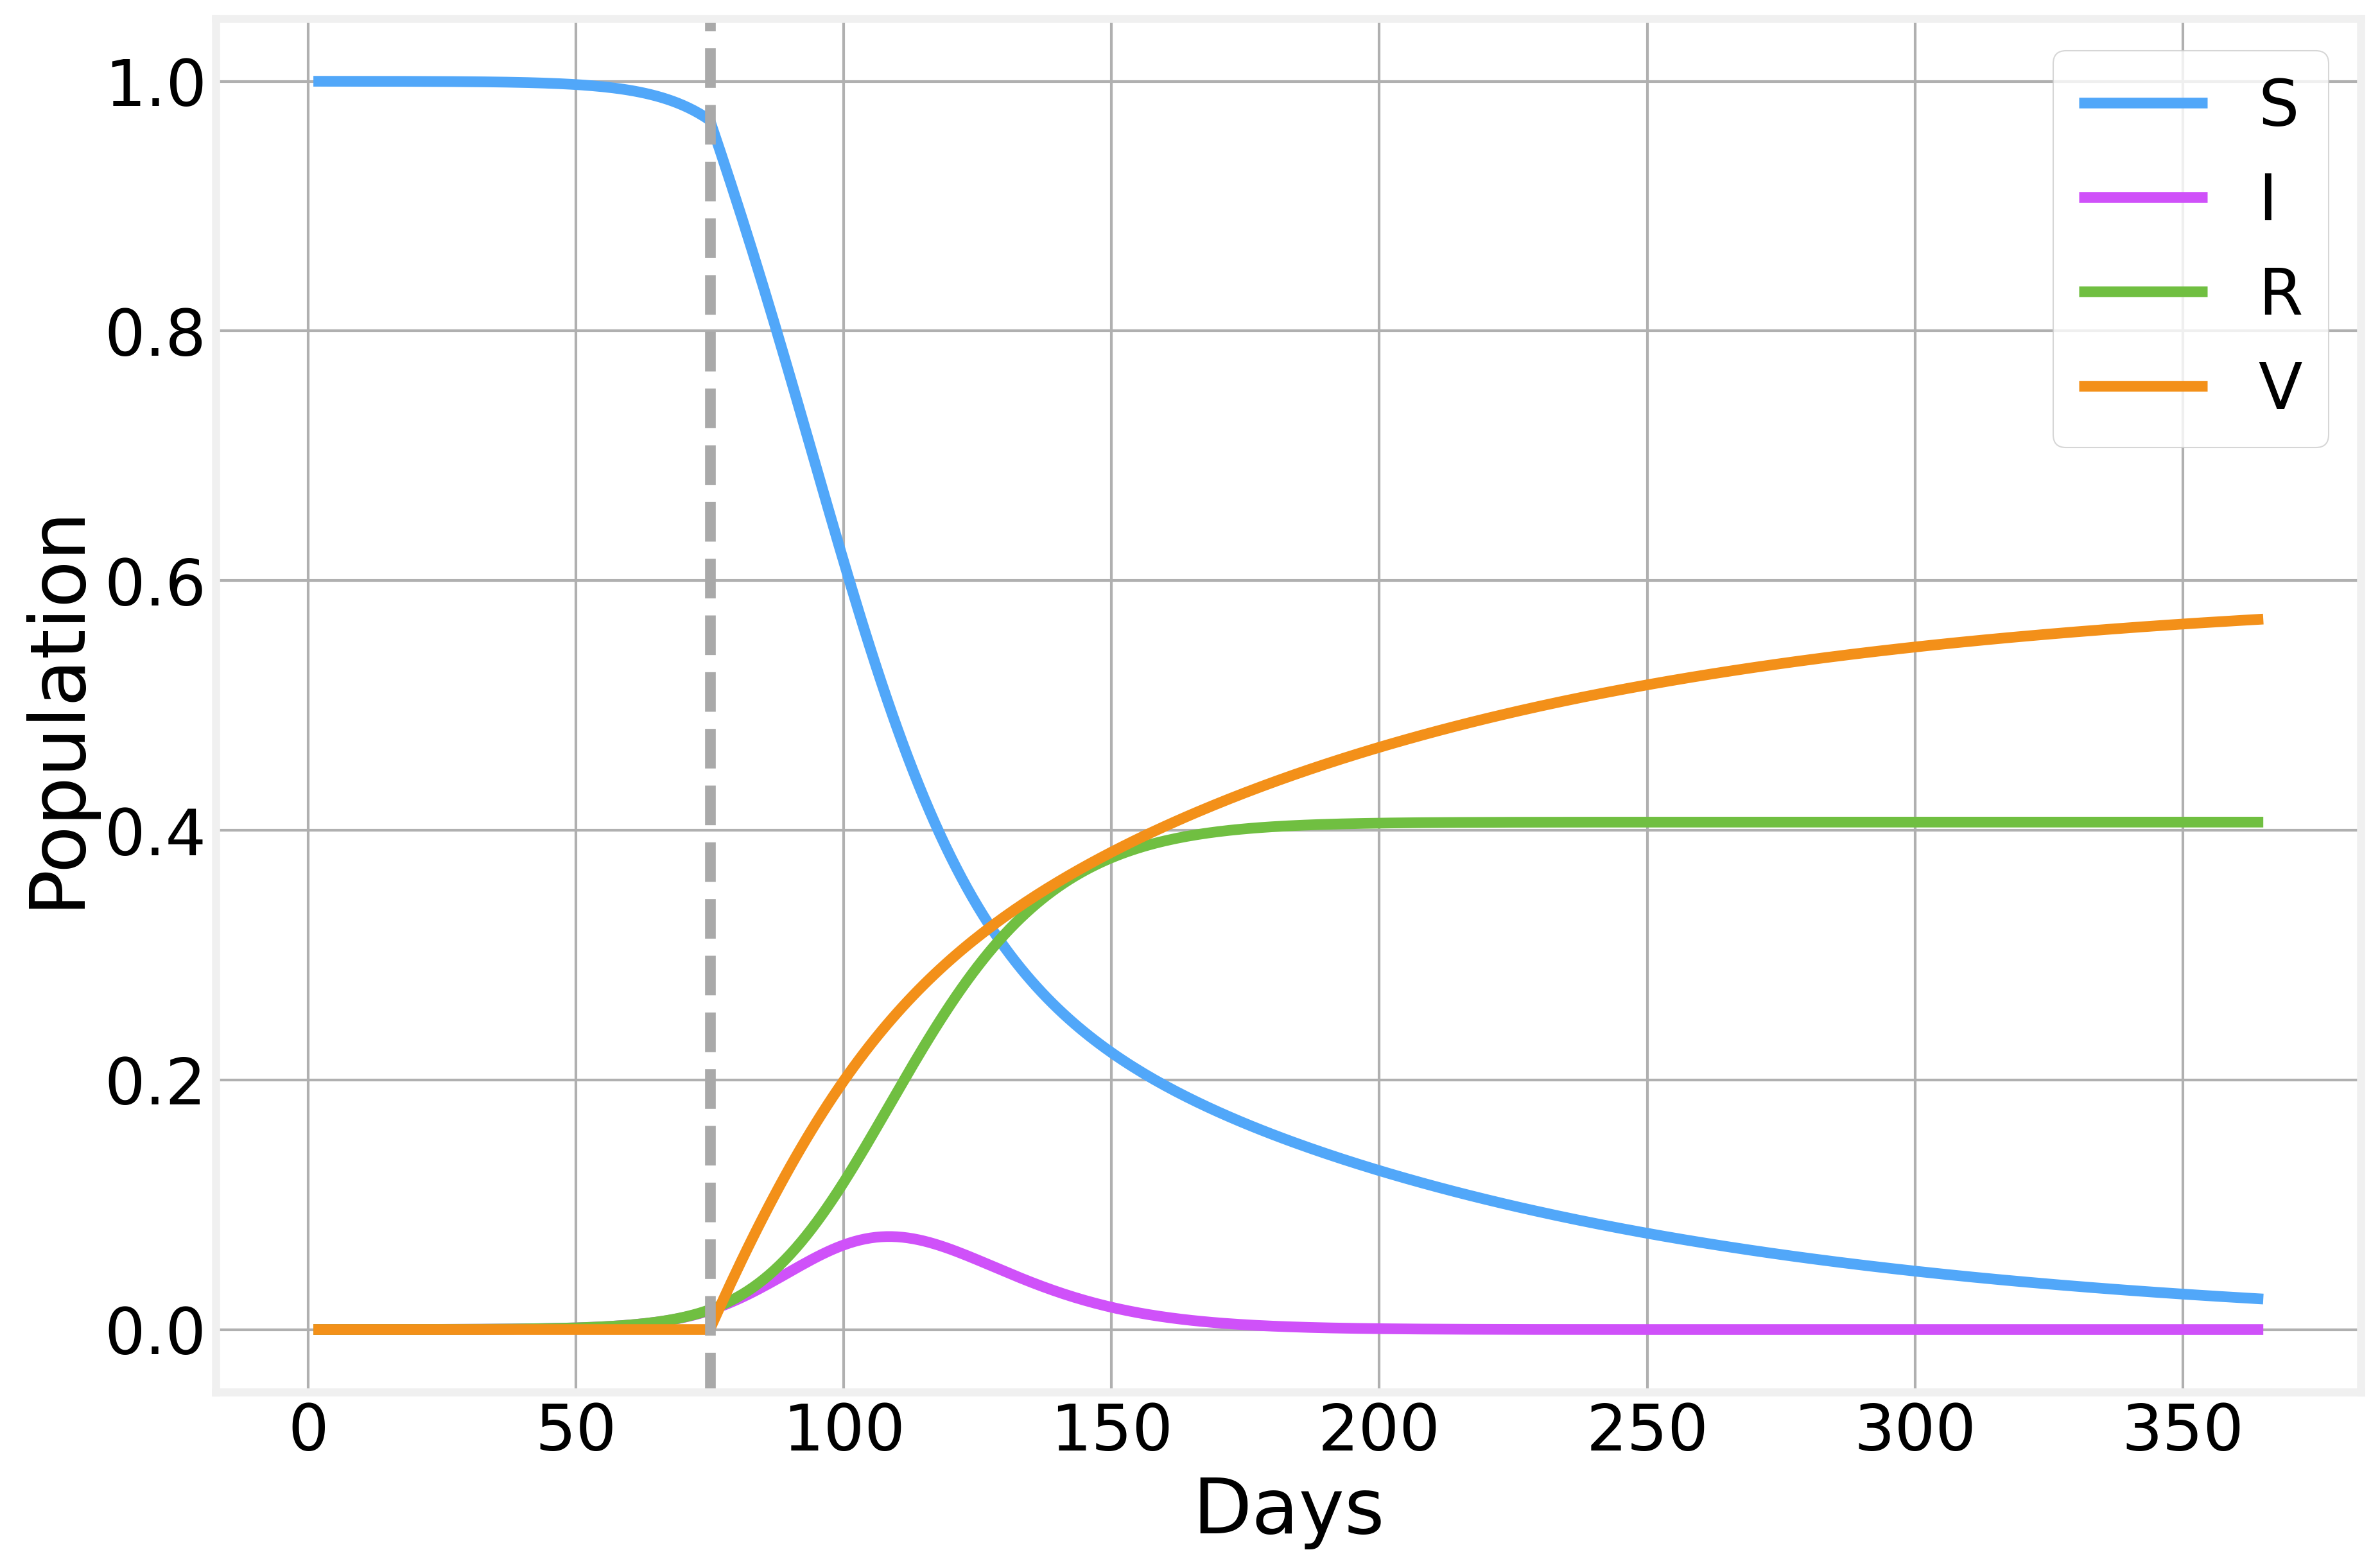

In [12]:
ax=(Vaccine_SIR).plot()
ax.axvline(x=vaccination_start, 
           label='Vaccination Starts', linestyle='--', color='darkgray')
ax.set_xlabel('Days')
ax.set_ylabel('Population')
plt.gcf().patch.set_facecolor((1, 1, 1))

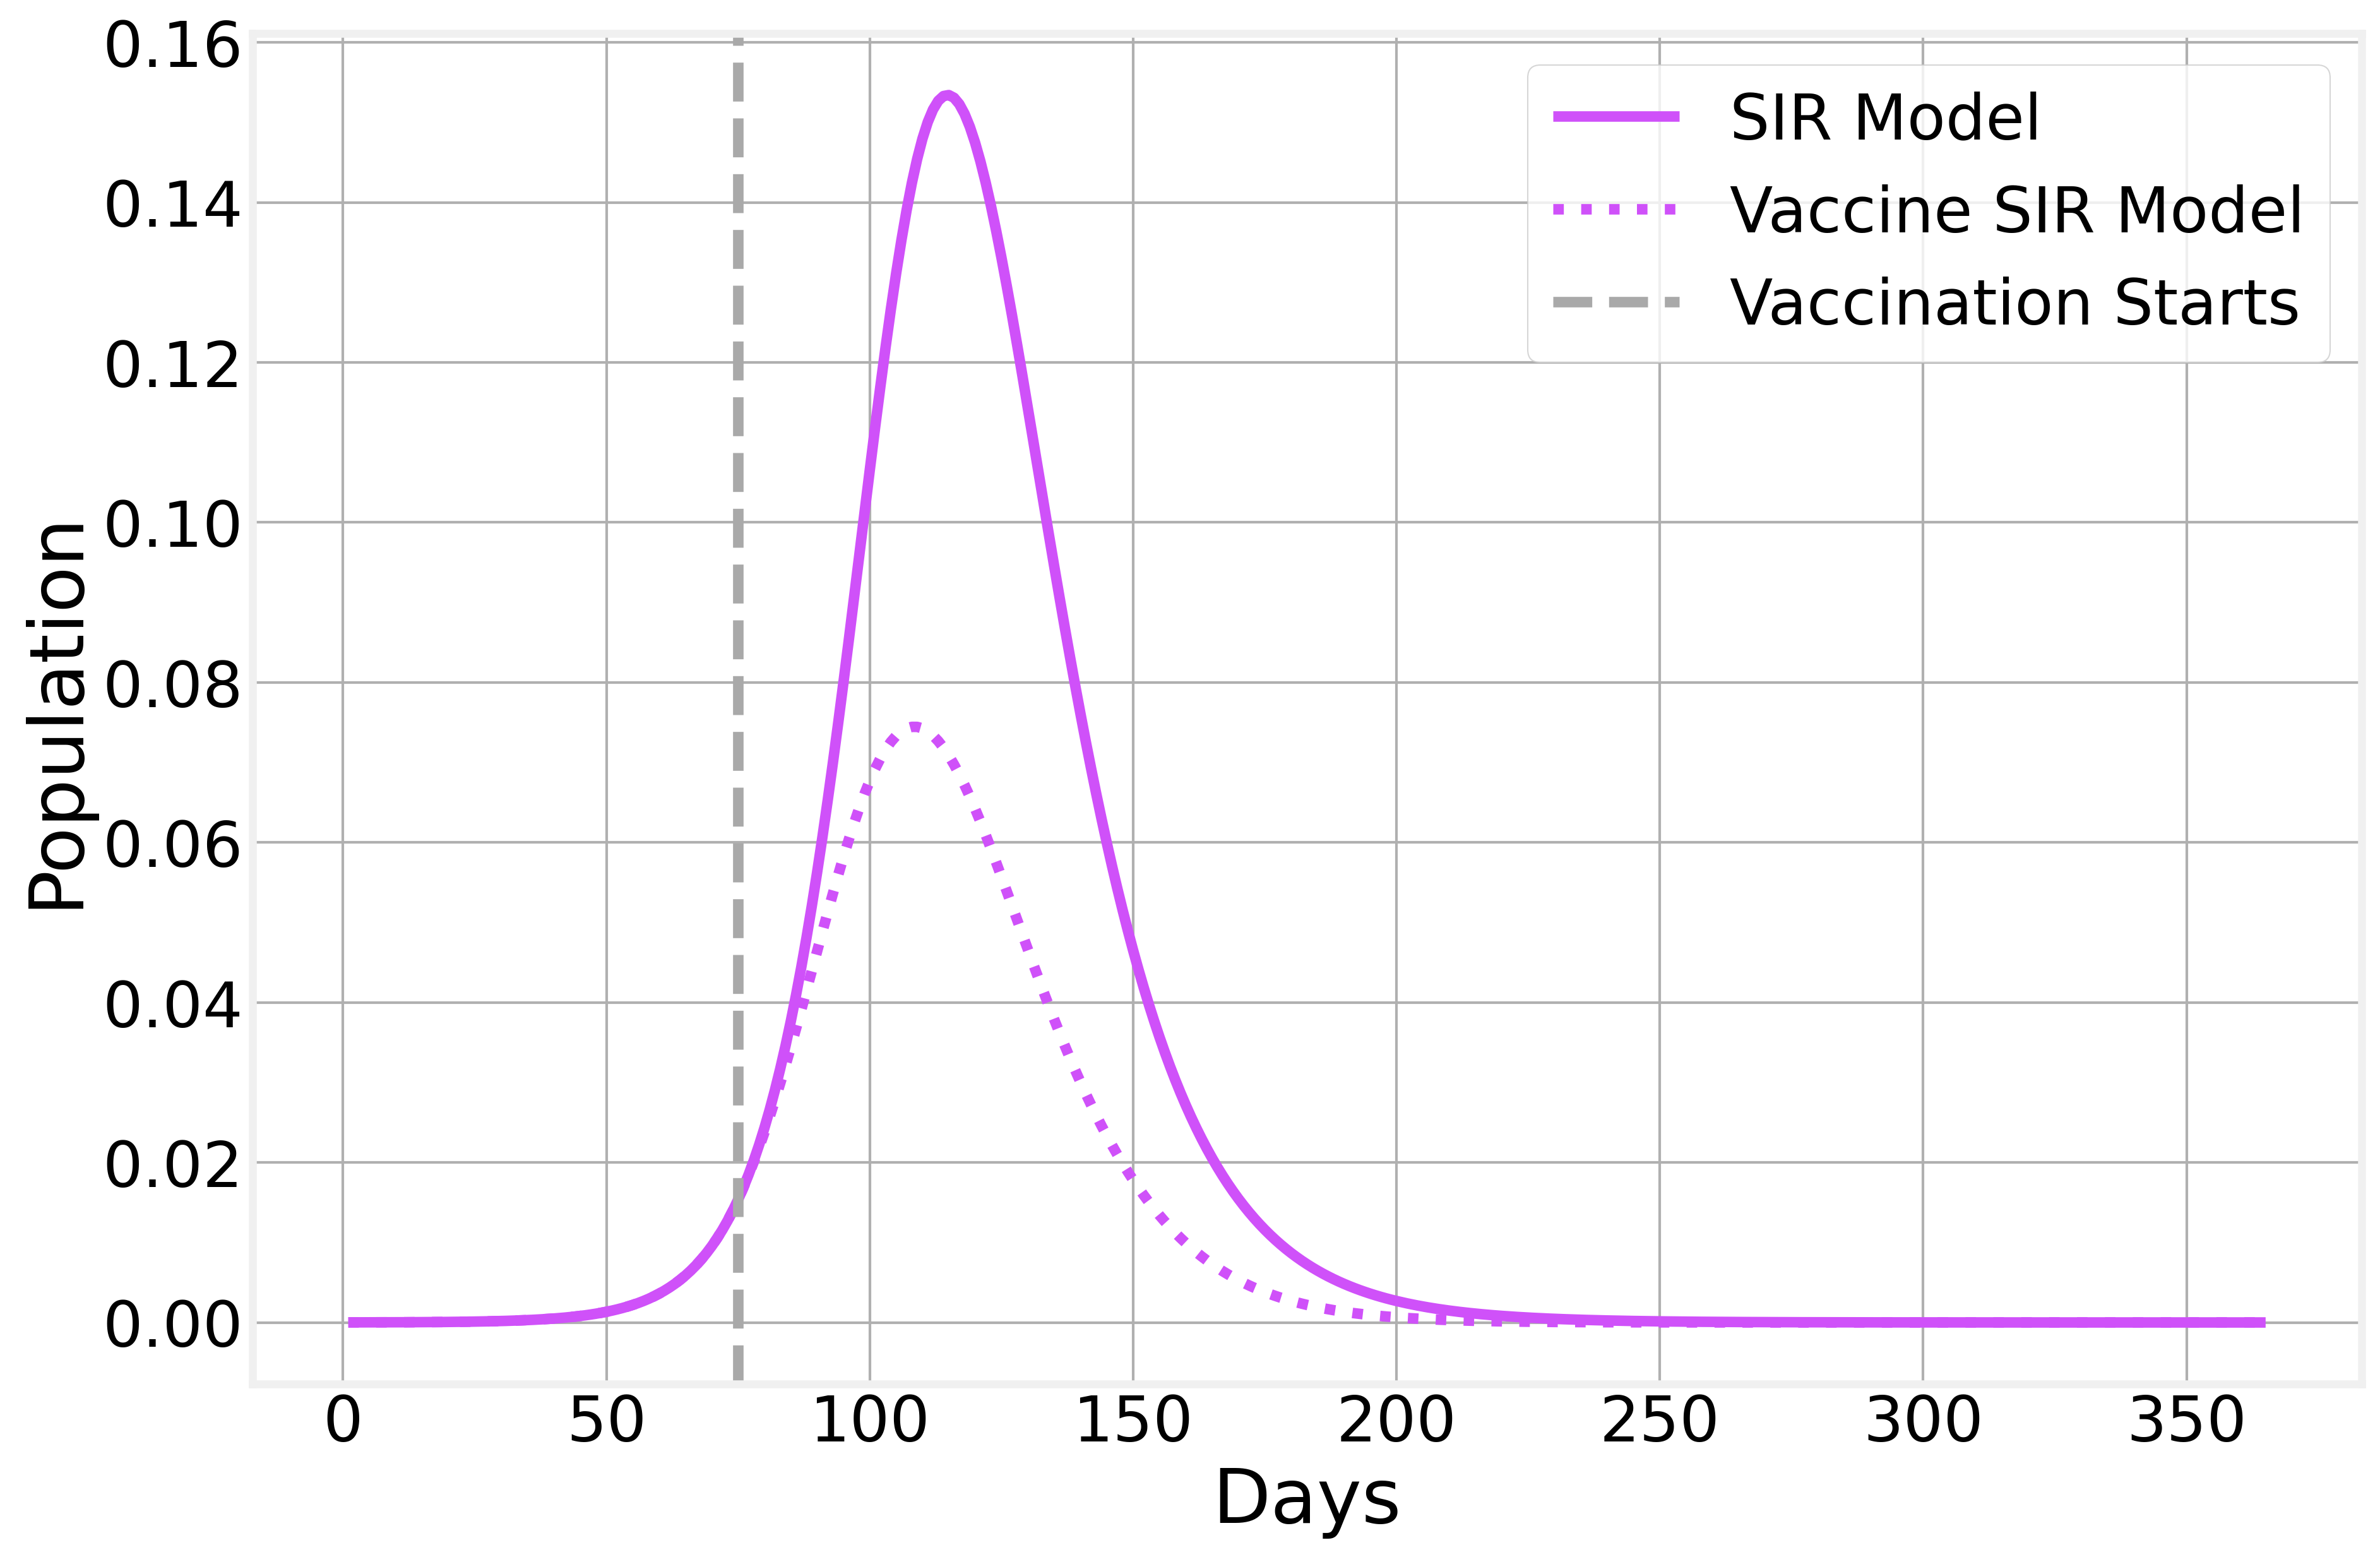

In [13]:
ax=(SIR.I/N).plot(label='SIR Model', color=colors[1])
(Vaccine_SIR.I/N).plot(label='Vaccine SIR Model', color=colors[1], linestyle=':')
ax.axvline(x=vaccination_start, 
           label='Vaccination Starts', linestyle='--', color='darkgray')
ax.set_xlabel('Days')
ax.set_ylabel('Population')
ax.legend()
plt.gcf().patch.set_facecolor((1, 1, 1))

So far we've been assuming that the vaccine offers 100% protection, however, that's not necessarily true. If instead we have a vaccine with just 90% efficacy

In [14]:
efficacy = 0.5

In [15]:
Vaccine_SIVIR = EpiModel()
Vaccine_SIVIR.add_interaction('S', 'I', 'I', beta)
Vaccine_SIVIR.add_spontaneous('I', 'R', mu)
Vaccine_SIVIR.add_vaccination('S', 'V', daily_vaccination_rate, vaccination_start)
Vaccine_SIVIR.add_interaction('V', 'VI', 'VI', beta*(1-efficacy))
Vaccine_SIVIR.add_interaction('V', 'VI', 'I', beta*(1-efficacy))
Vaccine_SIVIR.add_interaction('S', 'I', 'VI', beta*(1-efficacy))
Vaccine_SIVIR.add_spontaneous('VI', 'VR', mu)


print(Vaccine_SIVIR)

Epidemic Model with 6 compartments and 7 transitions:

S + I = I 0.200000
S + VI = I 0.100000
S -> V 0.010000 starting at 75 days
I -> R 0.100000
V + VI = VI 0.100000
V + I = VI 0.100000
VI -> VR 0.100000

R0=2.00


In [16]:
Vaccine_SIVIR.integrate(365, S=N-I0, I=I0, R=0)

In [17]:
compartment_colors = [*colors[:4], colors[5], colors[8]]
color_dict = dict(zip(Vaccine_SIVIR.transitions.nodes, compartment_colors))

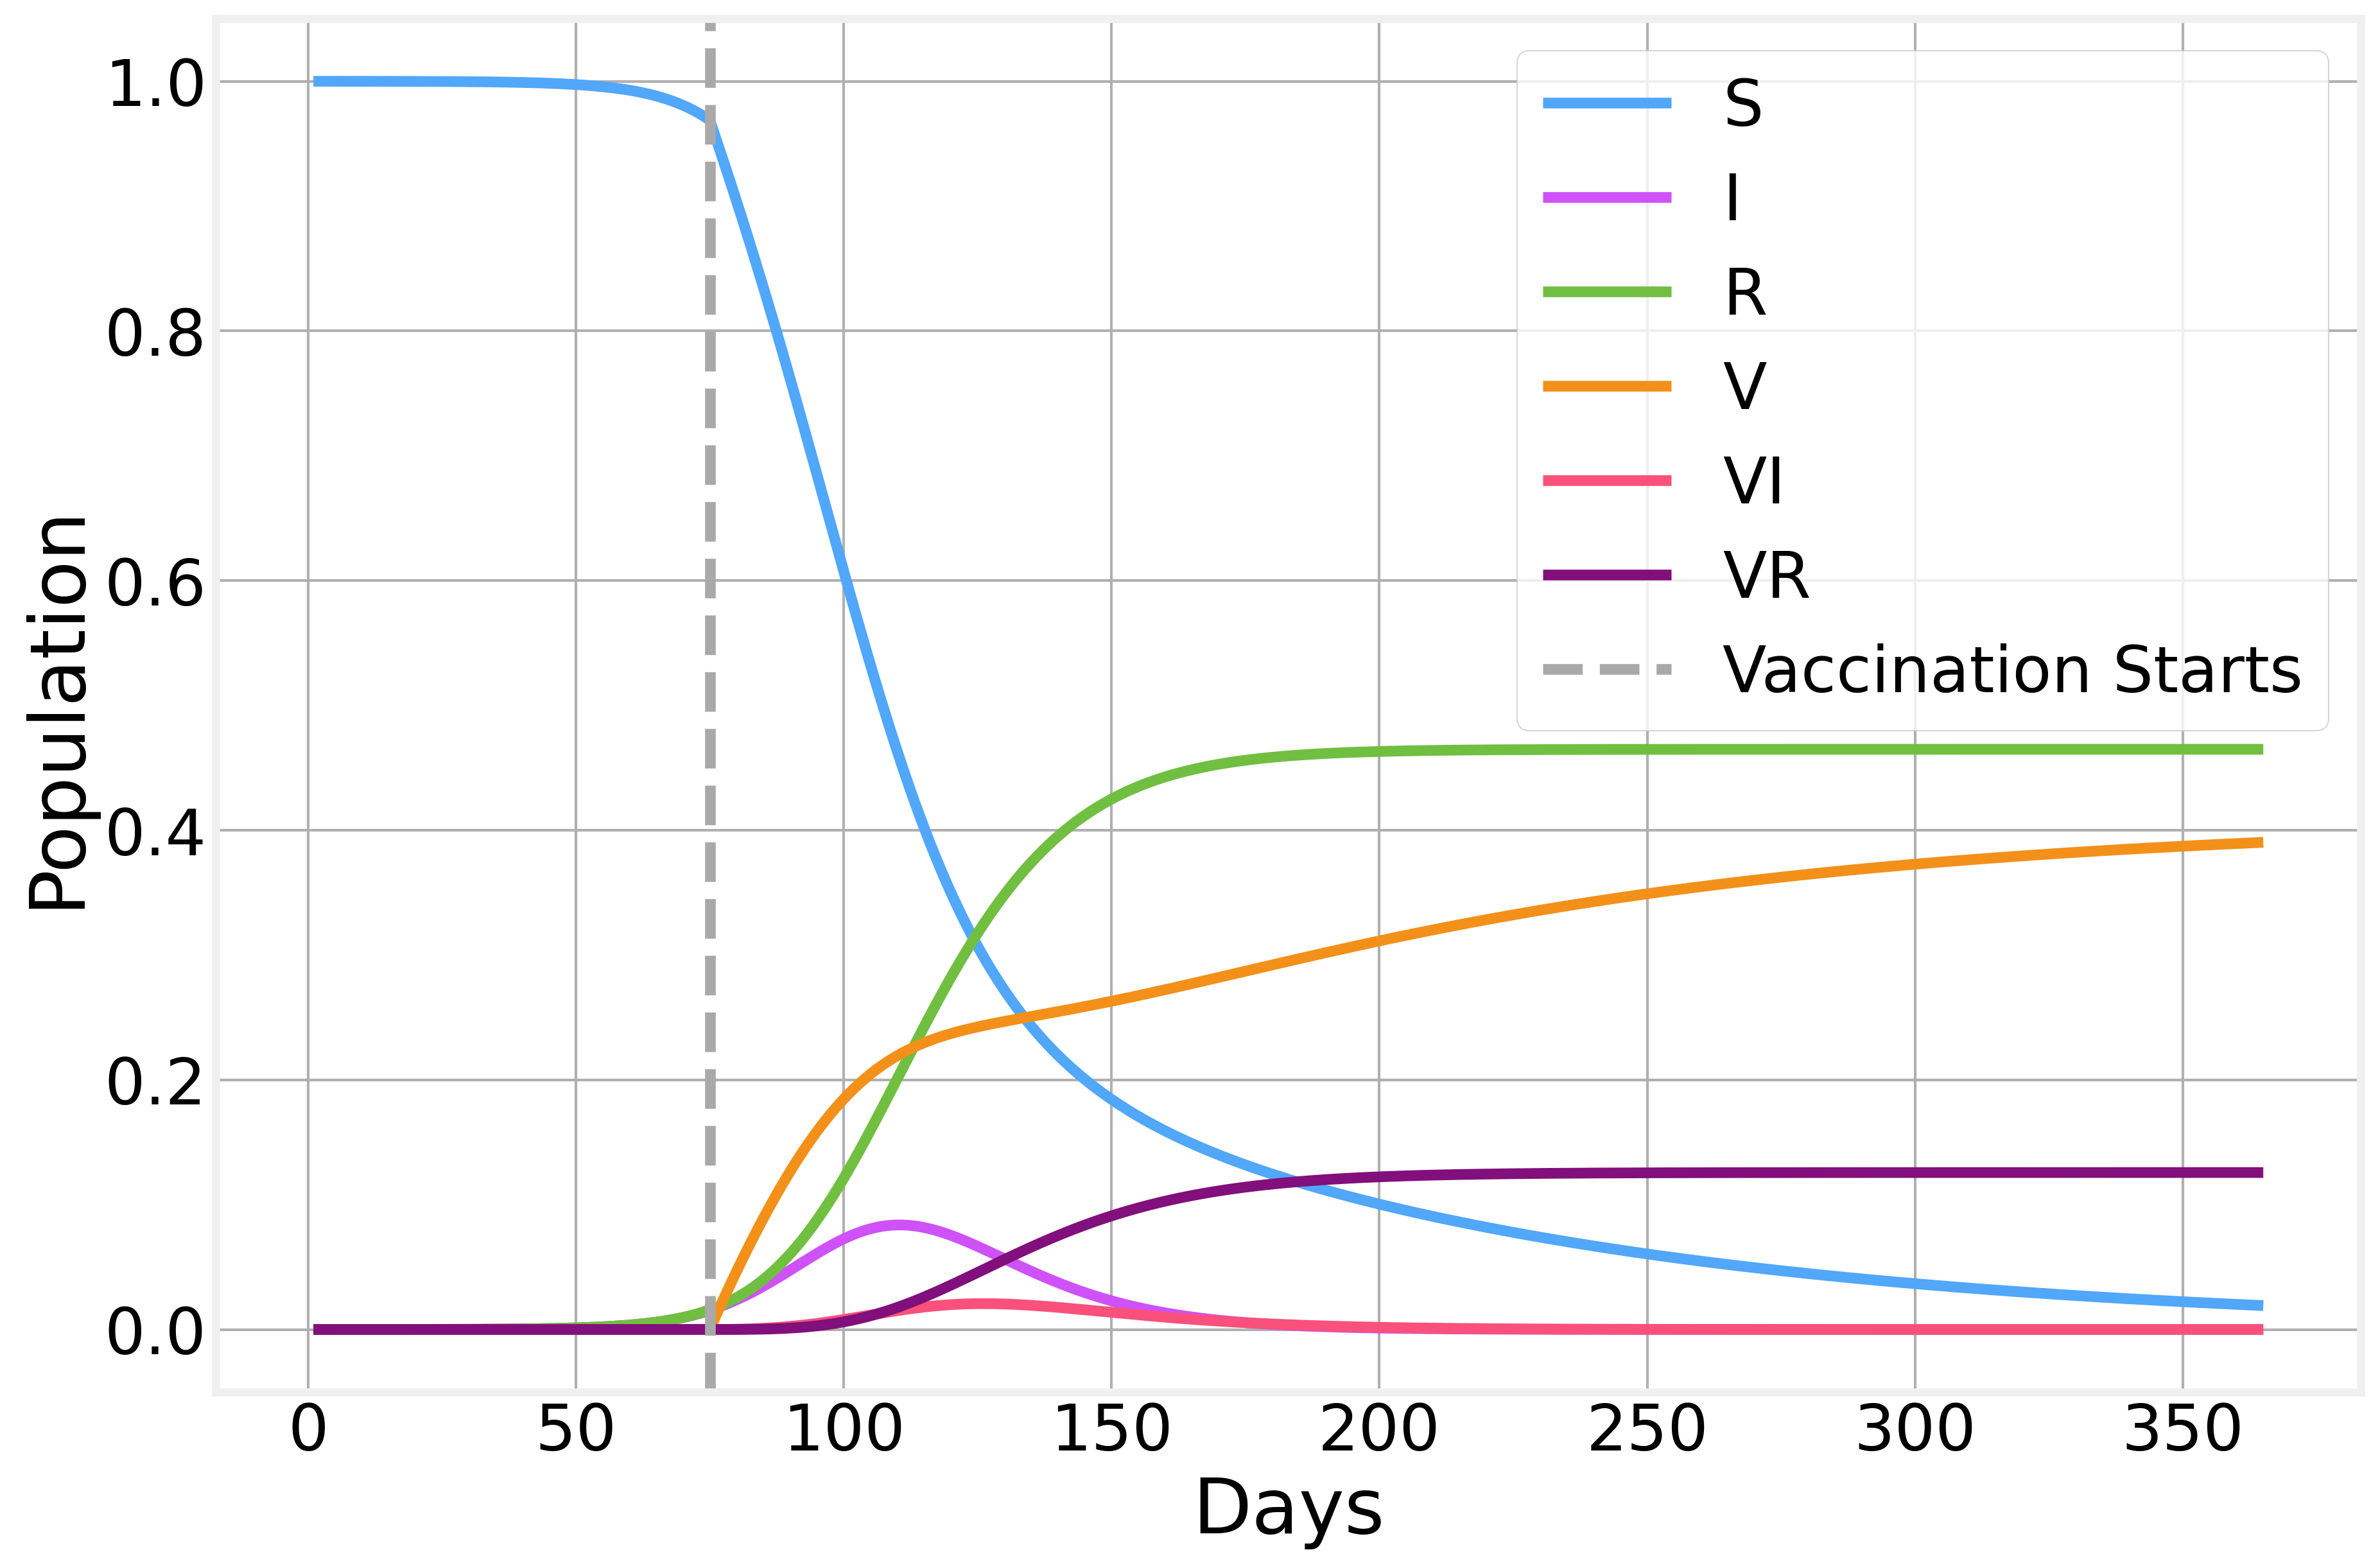

In [18]:
ax = (Vaccine_SIVIR).plot(color=compartment_colors)
ax.axvline(x=vaccination_start, 
           label='Vaccination Starts', linestyle='--', color='darkgray')
ax.legend(loc='upper right')
ax.set_xlabel('Days')
ax.set_ylabel('Population')
plt.gcf().patch.set_facecolor((1, 1, 1))

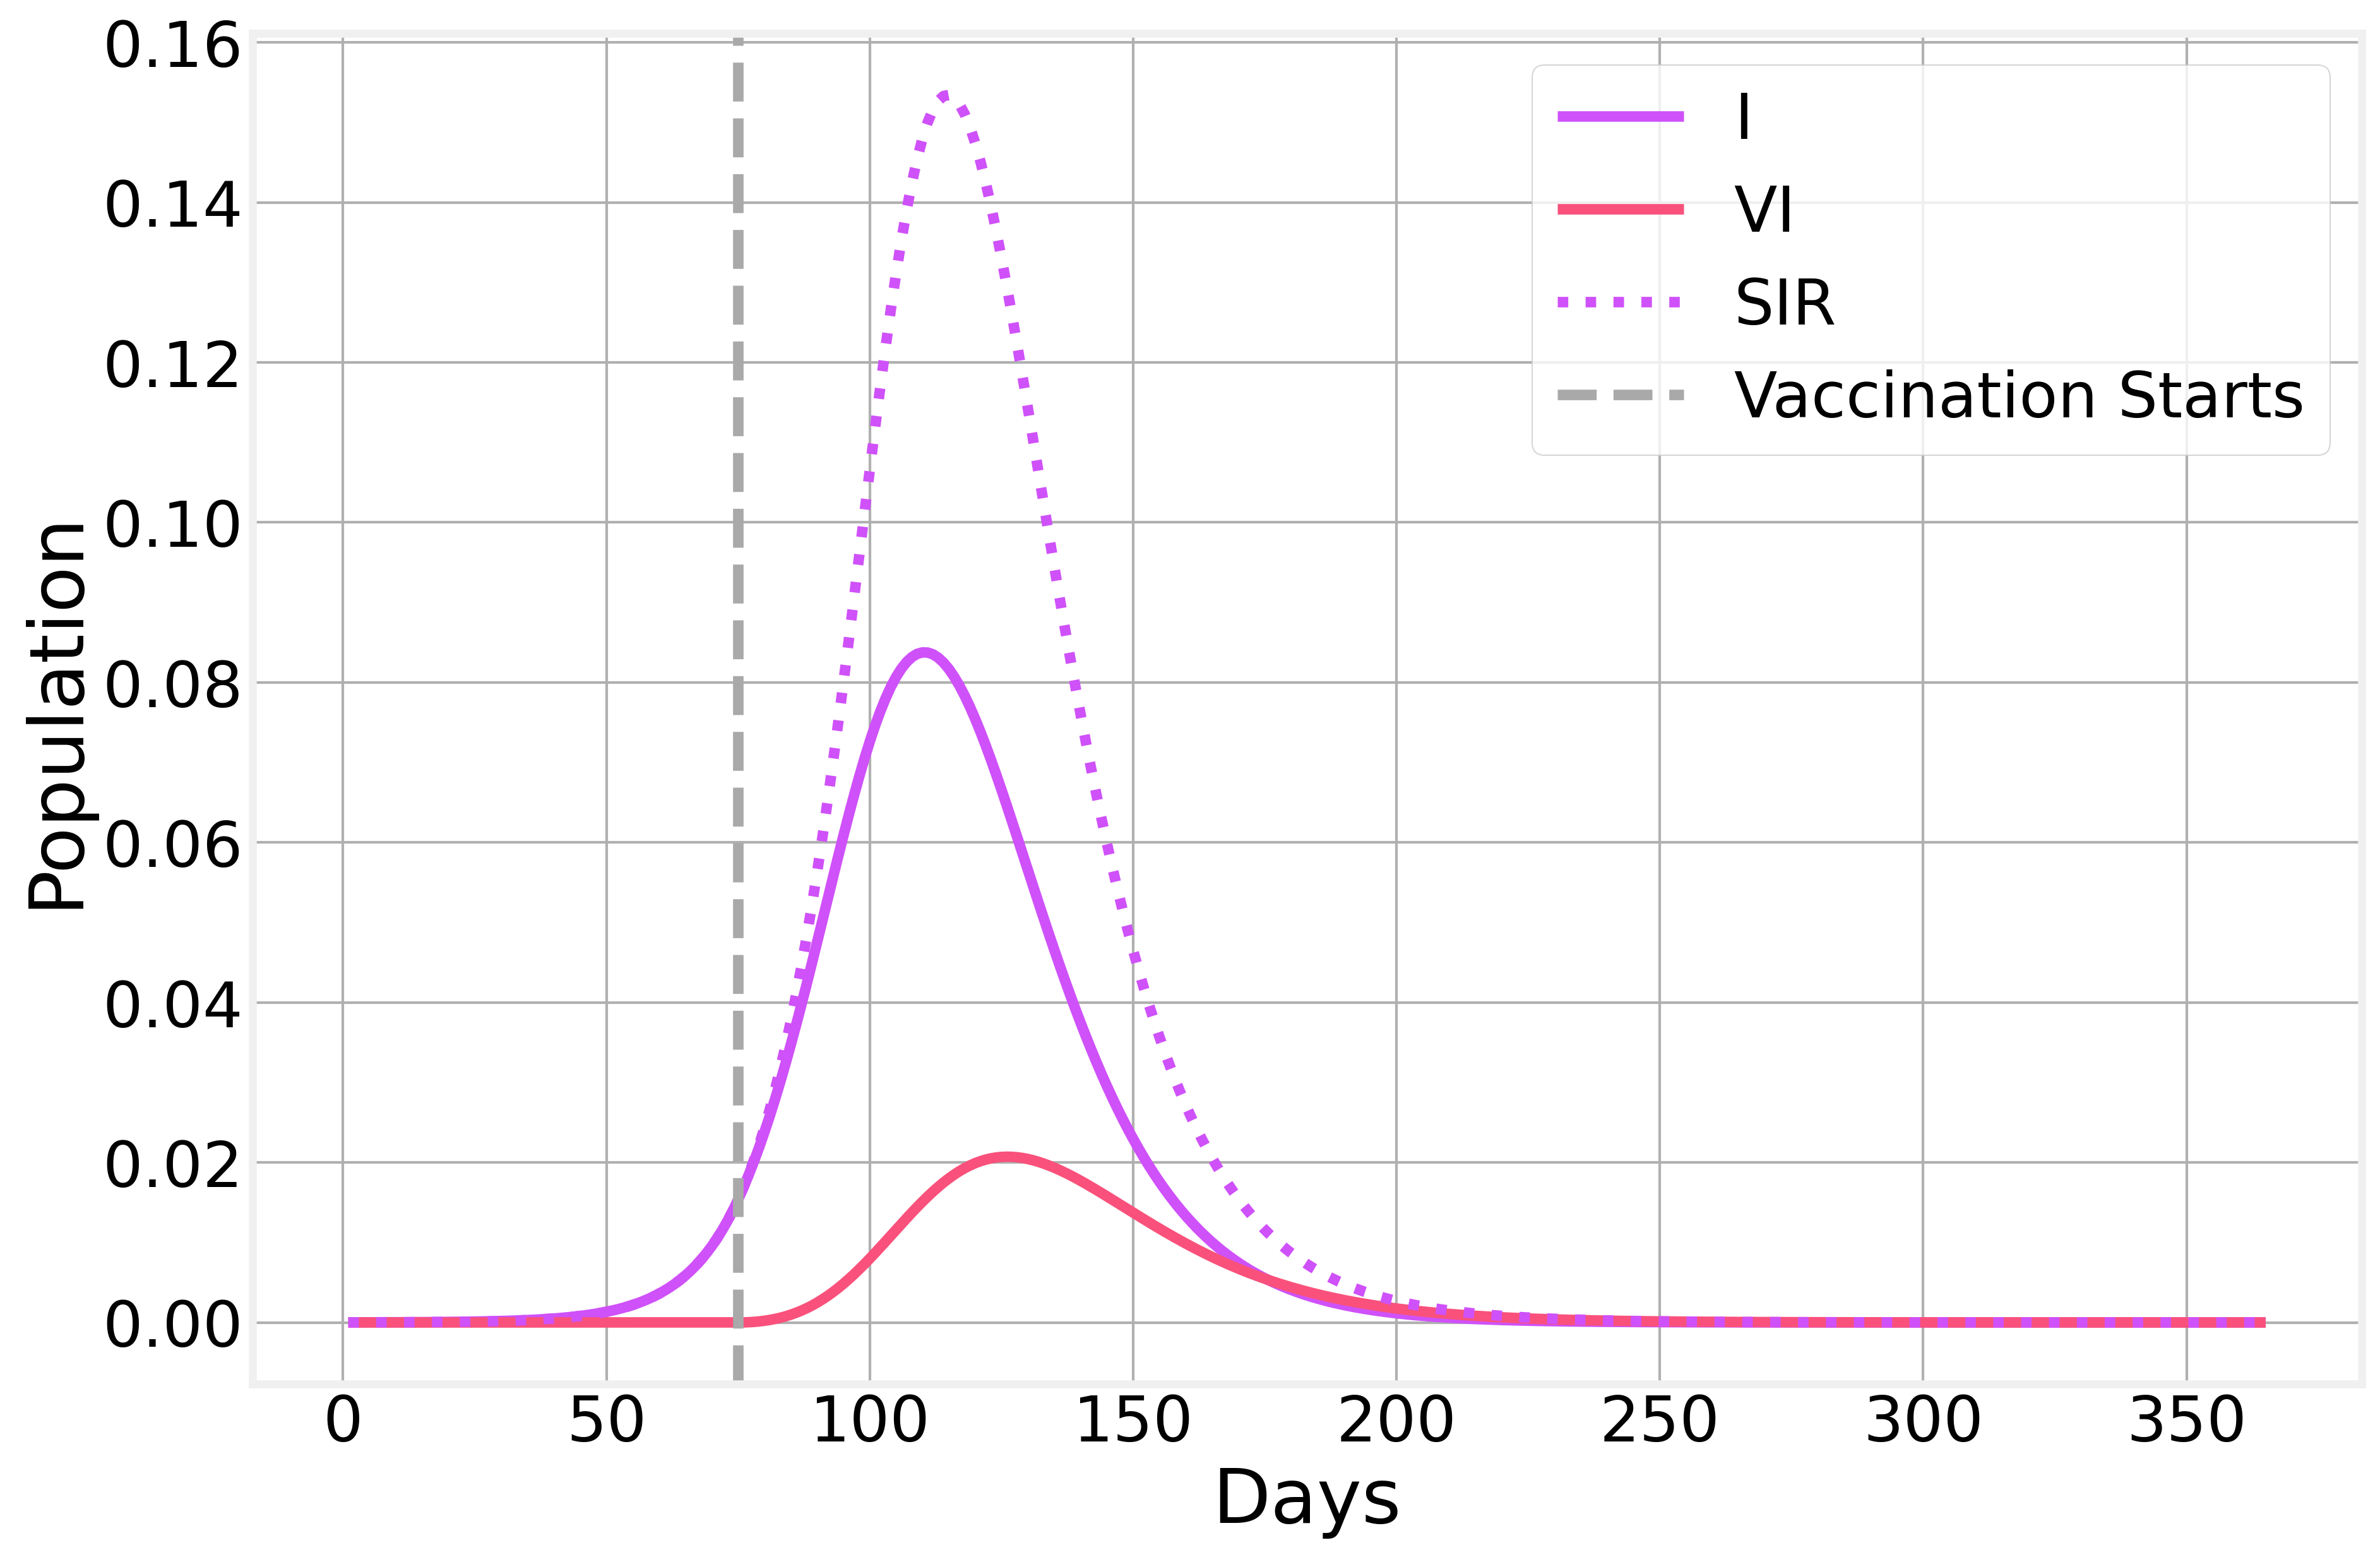

In [19]:
ax = (Vaccine_SIVIR[['I', 'VI']]/N).plot(color=[color_dict['I'], color_dict['VI']])
(SIR.I/N).plot(ax=ax, label='SIR', color=colors[1], linestyle=':')
ax.axvline(x=vaccination_start, 
           label='Vaccination Starts', linestyle='--', color='darkgray')

ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Population')
plt.gcf().patch.set_facecolor((1, 1, 1))

In [20]:
proportion = Vaccine_SIVIR[['I', 'VI']].copy()
proportion = proportion.T.div(proportion.sum(axis=1)).T

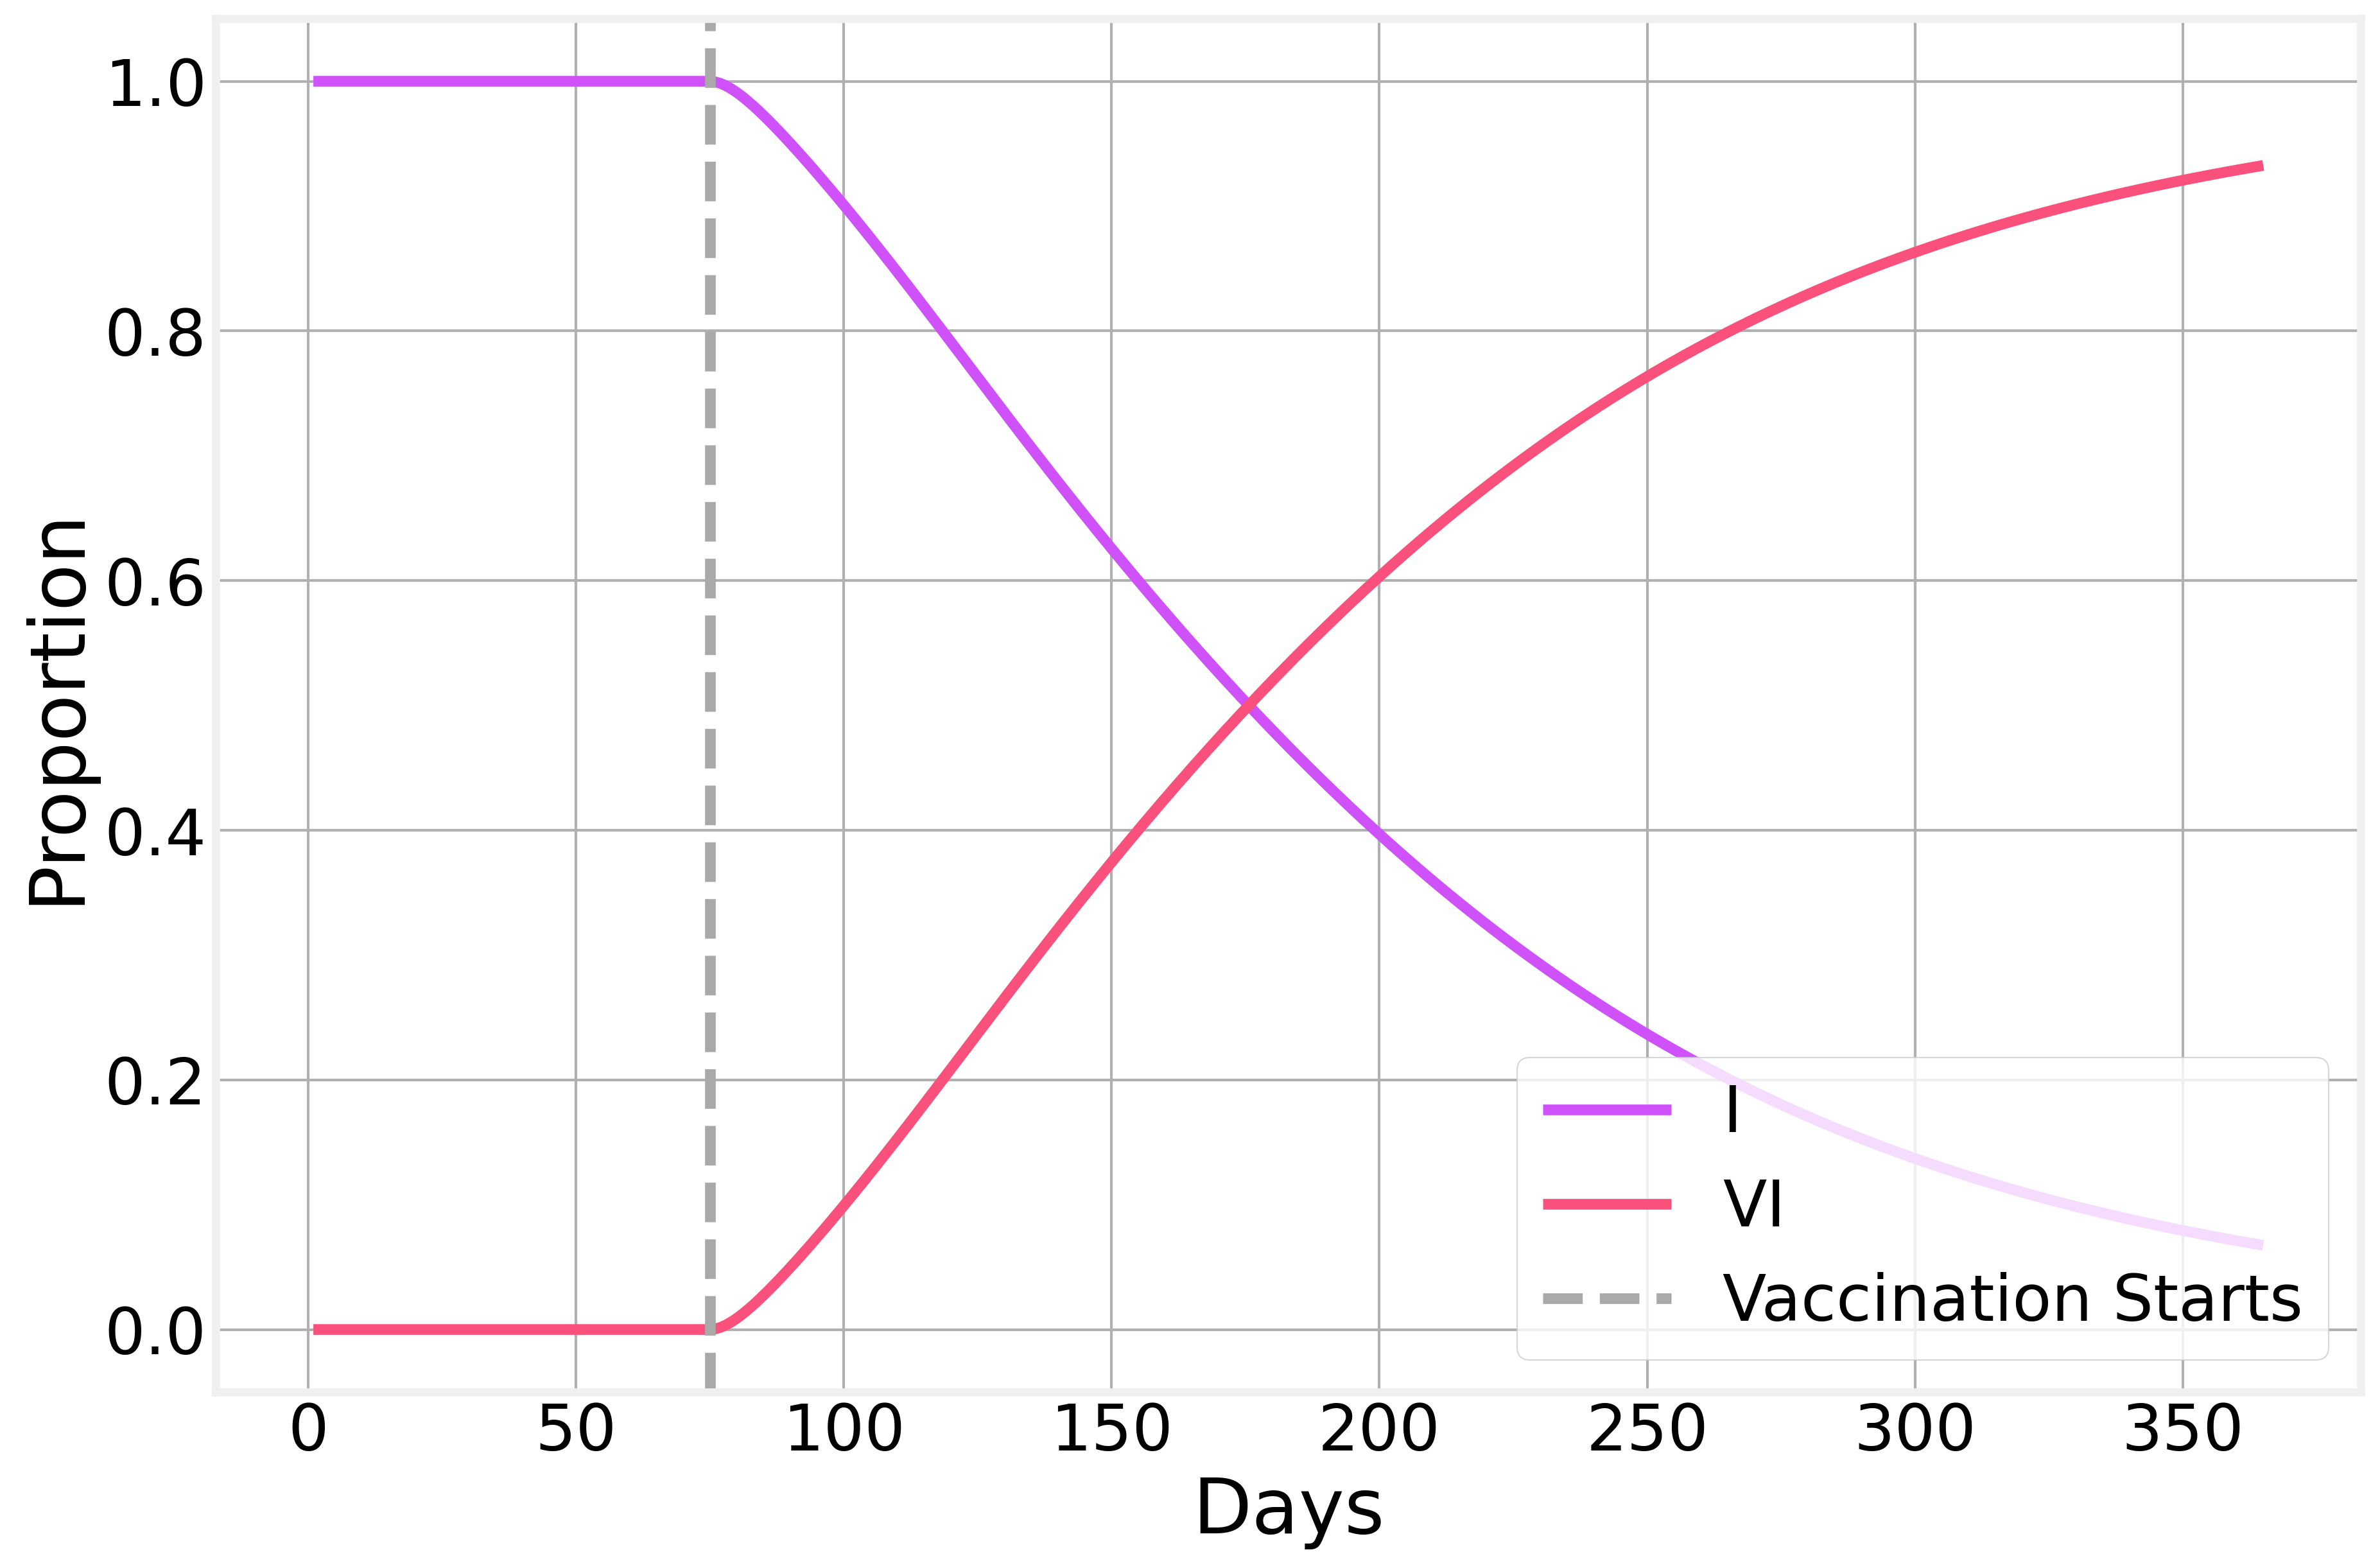

In [21]:
ax = proportion.plot(color=[color_dict['I'], color_dict['VI']])
ax.axvline(x=vaccination_start, 
           label='Vaccination Starts', linestyle='--', color='darkgray')
ax.legend(loc='lower right')
ax.set_xlabel('Days')
ax.set_ylabel('Proportion')
plt.gcf().patch.set_facecolor((1, 1, 1))

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>